# MILP optimization control with deep network transition

## Simple planning problem with continuous states
In this simple planning problem, we are going to show learning the model directly from realtime data stream and apply optimization on the model. The data will be generated from a simulator, which represent a 2D maze problem. 

Package installation

In [1]:
!pip --quiet install keras
!pip --quiet install h5py

Package imports

In [2]:
%matplotlib inline
import random
import os
import json
import sys
import string
import unicodedata
#Numpy and Scipy
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from scipy.spatial import distance
#KERAS
from keras.layers import Dense, Activation,Dropout
from keras.models import Sequential
from keras.regularizers import l1,l2
from keras.models import load_model

Using TensorFlow backend.


## Data Generation Part
### 1. Maze problem domain simulator

Brief Discription of this domain simulator

1. Define a 2D maze, which allows agent move continously in this domain. 
2. Has one Goal state and one start state. 
3. Allows to define obstacles that agent cannot move in, or it will transfered to jail.
4. There is a jail location that outside maze domain.
5. Agent alive in deadend in the period of tolerate time steps


In [3]:
'''
Created on Oct 6, 2016

This class has two construction functions.
1. From data
2. From initial settings

Example of 2D maze setting

initial_setting = {
    "maze_bound"        : (0,0,10,10),             #Continous state bound
    "obstacles"         : [(1,1,3,3),(5,4,6,6.5)], #Some obstacles that never crosspassing
    "current_state"     : (0,0,0,1),               #Current State in X,Y and If in Jail
    "action_range"      : (-0.5,0.5),              #The effective action range
    "action_dim"        : 2,                       #Dimension of Actions
    "goal_state"        : (10,10,0,1),             #The goal state to finish running
    "jail_location"     : (-1,-1,1,0),             #Jain location
    "deadend_toleration": 2                        #How many step left after getting into jail
                   }
@author: wuga
'''

class DeterministicMaze(object):
    
    def __init__(self, setting):
        self.__dict__.update(setting)
        self.backup = setting
        self.X_AXIS = 0
        
    def Reset(self):
        backup=self.backup
        self.__dict__.update(backup)
        self.backup = backup
        self.X_AXIS = 0
    
    def UpdateState(self,new_state):
        self.current_state = new_state
        
    def Apply(self, action):
        if not self.current_state[2]:
            x_axis=self.current_state[0]
            y_axis=self.current_state[1]
            x_axis=self.current_state[0]+action[0]
            if x_axis>self.maze_bound[2]:
                x_axis=self.maze_bound[2]
            if x_axis<self.maze_bound[0]:
                x_axis=self.maze_bound[0]
            y_axis=self.current_state[1]+action[1]
            if y_axis>self.maze_bound[3]:
                y_axis=self.maze_bound[3]
            if y_axis<self.maze_bound[1]:
                y_axis=self.maze_bound[1]
            self.UpdateState((x_axis,y_axis,0,1))
            if self.Collision():
                self.UpdateState(self.jail_location)
        else:
            self.deadend_toleration=self.deadend_toleration-1
        return self.current_state
                
    def StateIn(self, area, position):
        if (position[0] >= area[0]) and (position[0] <= area[2]) and \
        (position[1] >= area[1]) and (position[1] <= area[3]):
            return True
        else:
            return False
                
    def Collision(self):
        for area in self.obstacles:
            if self.StateIn(area, self.current_state):
                return True
        return False
    
    def IfGameEnd(self):
        if (self.current_state[0] == self.goal_state[0]) and \
        (self.current_state[1] == self.goal_state[1]) and \
        (self.current_state[2] == self.goal_state[2]):
            #print 'Get goal state! system resetted'
            self.Reset()
        if (self.deadend_toleration == 0):
            self.Reset()
            
    def DeltaDistance(self,new_state,old_state):
        delta=[]
        delta.append(new_state[0]-old_state[0])
        delta.append(new_state[1]-old_state[1])
        if (new_state[2]==1):
            delta.append(1)
            delta.append(0)
        else:
            delta.append(0)
            delta.append(1)
        return delta
    
    def GetCurrentState(self):
        return self.current_state

#### Simulator Test code
Please read the setting structure for creating maze.

This is an example of defining a maze

In [4]:
initial_setting = {
    "maze_bound"        : (0,0,10,10),             #Continous state bound
    "obstacles"         : [(1,1,3,3),(5,4,6,6.5)], #Some obstacles that never crosspassing
    "current_state"     : (0,0,0,1),               #Current State in X,Y and If in Jail
    "action_range"      : (-0.5,0.5),              #The effective action range
    "goal_state"        : (10,10,0,1),             #The goal state to finish running
    "jail_location"     : (-1,-1,1,0),             #Jain location
    "deadend_toleration": 2,                       #How many step left after getting into jail
    "action_dim"        : 2                        #Dimension of Actions    
    }

# Maze=DeterministicMaze(initial_setting)
# print Maze.current_state
# action1=(0,11)
# Maze.Apply(action1)
# action2=(1,10)
# Maze.Apply(action2)
# print Maze.current_state

#### Supporting Functions

In [5]:
#Given local path, find full path
def PathFinder(path):
    script_dir = os.path.dirname('__file__')
    fullpath = os.path.join(script_dir,path)
    return fullpath

#Read Data for Deep Learning
def ReadData(path):
    fullpath=PathFinder(path)
    return genfromtxt(fullpath, delimiter=',')

### 2. Planner
This planner is a random walker, who will explore the maze randomly. This is just for generate more random data to support transition function training. 

In [6]:
class RandomWalk(object):
    def __init__(self, actiondim, ranges):
        self.ranges=ranges
        self.actiondim=actiondim
    
    def Go(self):
        stride=[]
        for i in range(self.actiondim):
            stride.append(random.triangular(self.ranges[0],self.ranges[1], 0.2))
        print stride
        return stride

In [7]:
Maze=DeterministicMaze(initial_setting)
Planner=RandomWalk(Maze.action_dim,Maze.action_range)
for i in range(10):
    Planner.Go()

[0.20836998187454198, -0.1422587029004846]
[0.139310161917234, -0.2084440538673198]
[0.19027792742300342, 0.10936172196411265]
[0.15671453285574188, -0.19742517009378785]
[0.006553637850157945, 0.21794205184538662]
[0.2824512554705521, -0.40784771992642765]
[-0.2956297831407985, -0.12461429687623399]
[-0.378017524667906, -0.25925991091739786]
[0.2983589669540238, -0.13045555373876]
[0.23421007361647928, 0.10125535429193133]


### 3. Data writter
This class combine the simulator and planner to generate some routing data from multiple tries. 

In [8]:
class DataGenerator(object):
    def __init__(self, model):
            self.maze=model
            self.planner=RandomWalk(self.maze.action_dim,self.maze.action_range)
            
    def WriteData(self,size,datapath,labelpath):
        fulldatapath=PathFinder(datapath)
        fulllabelpath=PathFinder(labelpath)
        datafile = open(fulldatapath,'w')
        labelfile = open(fulllabelpath,'w')
        for i in range(0,size):
            self.maze.IfGameEnd()
            action=self.planner.Go()
            old_state=Maze.GetCurrentState()
            self.maze.Apply(action)
            new_state=self.maze.GetCurrentState()
            Data=list(old_state)+action
            #Label=list(new_state)
            Label=self.maze.DeltaDistance(new_state,old_state)
            datafile.write(','.join(map(str, Data))+'\n')
            labelfile.write(','.join(map(str, Label))+'\n')
        datafile.close()
        labelfile.close()

#### Call above classes!

In [17]:
Maze=DeterministicMaze(initial_setting)
Generator=DataGenerator(Maze)
Datapath="StateActionData.txt"
Labelpath="StateActionLabel.txt"
Generator.WriteData(100000,Datapath,Labelpath)

NameError: name 'DeterministicMaze' is not defined

## Transition Function Learning Part
### 1. Deep Net Structure

In [9]:
import tensorflow as tf
tf.python.control_flow_ops = tf
class FullyConnectedDeepNet(object):
    '''

    '''
    def __init__(self,observ,hidden,output,num_layers,drop_out):
        self.drop_out=drop_out
        self.DeepNet = Sequential()
        #self.Autoencoder.add(Dropout(0.5, input_shape=(observ,)))
        self.DeepNet.add(Sequential([Dense(hidden, input_dim=observ), Activation('relu')]))
        self.DeepNet.add(Dropout(drop_out))
        if num_layers > 1:
            for i in range(num_layers-1):
                self.DeepNet.add(Sequential([Dense(hidden, input_dim=hidden), Activation('relu')]))
                self.DeepNet.add(Dropout(drop_out))
        self.DeepNet.add(Dense(output, input_dim=hidden))
        self.DeepNet.compile(optimizer='rmsprop', loss='mse')
    
    def Train(self,data,label,epoch):
        self.DeepNet.fit(data, label, nb_epoch=epoch)

    def Test(self,datapoint):
        return self.DeepNet.predict(datapoint, batch_size=128, verbose=0)
    
    def LoadModel(self,modelpath):
        self.DeepNet=load_model(modelpath)
    
    def Save(self,modelpath):
        self.DeepNet.save(modelpath)
        
    def GetModel(self):
        return self.DeepNet

#### Training

In [72]:
Datapath="StateActionData.txt"
Labelpath="StateActionLabel.txt"
DNN_DELTA=FullyConnectedDeepNet(6,100,2,4,0.1)
DNN_INJAIL=FullyConnectedDeepNet(6,100,2,1,0.1)
Full_Data=ReadData(Datapath)
Full_Label=ReadData(Labelpath)
Train_Data = Full_Data[:90000]
Train_Label = Full_Label[:90000]
Test_Data = Full_Data[90000:]
Test_Label = Full_Label[90000:]
DNN_DELTA.Train(Train_Data,Train_Label[:,:2],30)
DNN_INJAIL.Train(Train_Data,Train_Label[:,2:],30)

Epoch 1/30
90000/90000 [==============================] - 15s - loss: 0.1226    
Epoch 2/30
90000/90000 [==============================] - 15s - loss: 0.0797    
Epoch 3/30
90000/90000 [==============================] - 15s - loss: 0.0718    
Epoch 4/30
90000/90000 [==============================] - 15s - loss: 0.0678    
Epoch 5/30
90000/90000 [==============================] - 15s - loss: 0.0667    
Epoch 6/30
90000/90000 [==============================] - 15s - loss: 0.0639    
Epoch 7/30
90000/90000 [==============================] - 15s - loss: 0.0635    
Epoch 8/30
90000/90000 [==============================] - 16s - loss: 0.0618    
Epoch 9/30
90000/90000 [==============================] - 16s - loss: 0.0617    
Epoch 10/30
90000/90000 [==============================] - 15s - loss: 0.0610    
Epoch 11/30
90000/90000 [==============================] - 16s - loss: 0.0604    
Epoch 12/30
90000/90000 [==============================] - 16s - loss: 0.0598    
Epoch 13/30
90000/90000 [

In [74]:
DNN_DELTA.Save("TransitionModel_DELTA.h5")
DNN_INJAIL.Save("TransitionModel_INJAIL.h5")

In [14]:
Datapath="StateActionData.txt"
Labelpath="StateActionLabel.txt"
Full_Data=ReadData(Datapath)
Full_Label=ReadData(Labelpath)
Train_Data = Full_Data[:90000]
Train_Label = Full_Label[:90000]
Test_Data = Full_Data[90000:]
Test_Label = Full_Label[90000:]
DNN_DELTA=FullyConnectedDeepNet(6,100,2,4,0.1)
DNN_INJAIL=FullyConnectedDeepNet(6,100,2,1,0.1)
DNN_DELTA.LoadModel("TransitionModel_DELTA.h5")
DNN_INJAIL.LoadModel("TransitionModel_INJAIL.h5")

In [15]:
# Show performance of the DNN model(Samples)
Test_Pred = np.concatenate((DNN_DELTA.Test(Test_Data), DNN_INJAIL.Test(Test_Data)), axis=1)
print Test_Pred[:3]
print Test_Label[:3]

[[ 0.00608246  0.16082352  0.00454286  0.99545717]
 [ 0.01034294  0.16091695  0.01641883  0.98358119]
 [-0.0132833   0.17351052  0.01983301  0.98016703]]
[[ -5.07482936e-04   1.53839747e-01   0.00000000e+00   1.00000000e+00]
 [  9.50891851e-03   1.53513529e-01   0.00000000e+00   1.00000000e+00]
 [ -1.01158453e-02   1.70352886e-01   0.00000000e+00   1.00000000e+00]]


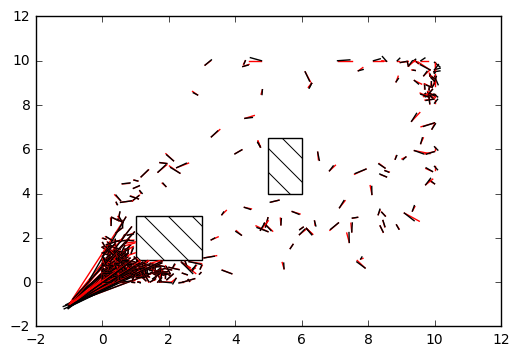

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def Virtualizing(Data, Label, Pred, Obstacles,SampleSize):
    sample_index=np.random.choice(len(Data), SampleSize)
    #print sample_index
    #print Train_Data[sample_index,:2],Train_Label[sample_index,:2]
    fig9 = plt.figure()
    ax9 = fig9.add_subplot(111)
    for i in sample_index:
        plt.plot([Data[i,0],Data[i,0]+Label[i,0]], [Data[i,1],Data[i,1]+Label[i,1]], 'r-',lw=1)
        plt.plot([Data[i,0],Data[i,0]+Pred[i,0]], [Data[i,1],Data[i,1]+Pred[i,1]], 'k-',lw=1)
    for j in range(len(Obstacles)):
        ax9.add_patch(patches.Rectangle((Obstacles[j][0], Obstacles[j][1]),
                                        Obstacles[j][2]-Obstacles[j][0], Obstacles[j][3]-Obstacles[j][1],
                                        hatch='\\', fill=False,linestyle='solid'))
    plt.show()

Virtualizing(Test_Data,Test_Label,Test_Pred,Maze.obstacles,500)

### 2.Weights Extraction Analysis

In [17]:
DNN_DELTA=FullyConnectedDeepNet(6,100,2,4,0.1)
# Train_Data=ReadData(Datapath)
# Train_Label=ReadData(Labelpath)
DNN_DELTA.LoadModel("TransitionModel_DELTA.h5")
for layer in DNN_DELTA.GetModel().layers: 
    g=layer.get_config()
    h=layer.get_weights() 
    print (g) 
    print (h)

TypeError: __init__() takes exactly 6 arguments (5 given)

The weight matrix is input_dim * output_dim, bias is vector with output_dim

The out put format is
target_node_name Activition_function [input_nodel_name weight_target_input]+ ...

We start from the first layer..

### 3. Create New File Layout for MILP

In [18]:
class NetTopology(object):
    def __init__(self,layers,drop_out):
        self.layers=layers
        self.input_dim=layers[0].get_config()[0].get('config').get('input_dim')
        self.num_upper_layers=len(layers)
        self.nodenames=[]
        self.drop_out=drop_out
        layernodename=[]
        for i in range(0, self.input_dim):
            layernodename.append('N0'+str(i))
        layernodename.append('B0')
        self.nodenames.append(layernodename)
        
    def LayerWiseTransform(self,layer,layer_id, lastlayer=False, hiddenstart='N', writefile=False, filehandler=None):
        if not lastlayer:
            input_dim = layer.get_config()[0].get('config').get('input_dim')
            output_dim = layer.get_config()[0].get('config').get('output_dim')
            activation = layer.get_config()[1].get('config').get('activation')
        else:
            input_dim = layer.get_config().get('input_dim')
            output_dim = layer.get_config().get('output_dim')
            activation = layer.get_config().get('activation')
        layernodename=[]
        weights_bias=layer.get_weights()
        weights=weights_bias[0]
        bias=weights_bias[1]
        for i in range(0, output_dim):
            layernodename.append(hiddenstart+str(layer_id)+str(i))
        for i in range(0, output_dim):
            row = [layernodename[i],activation]
            for j in range(0, input_dim):
                row.append(self.nodenames[-1][j])
                row.append(weights[j][i]*self.drop_out)
            row.append(self.nodenames[-1][-1])
            row.append(bias[i])
            if writefile:
                filehandler.write(','.join(map(str, row))+'\n')
            else:
                print ','.join(map(str, row))
        layernodename.append('B'+str(layer_id))
        self.nodenames.append(layernodename)
        
    def NetTransform(self,hiddenstart='N', writefile=False, filepath=None,overwrite=False):
        filehandler=None
        if writefile:
            fullpath=PathFinder(filepath)
            if overwrite is True:
                filehandler = open(fullpath,'w')
            else:
                filehandler = open(fullpath,'a')
        counter=0
        for i in range(0,self.num_upper_layers):
            if type(self.layers[i]) is not Dropout:
                if (i==self.num_upper_layers-1):
                    self.LayerWiseTransform(self.layers[i],counter+1, True, hiddenstart, writefile, filehandler)
                else:
                    self.LayerWiseTransform(self.layers[i],counter+1, False, hiddenstart, writefile, filehandler)
                counter=counter+1
        if writefile:
            filehandler.close()
        print 'Done!'
            
        
        

Topo_DELTA=NetTopology(DNN_DELTA.GetModel().layers,DNN_DELTA.drop_out)
Topo_DELTA.NetTransform('D',True, "Network_MIX.txt",True)
Topo_INJAIL=NetTopology(DNN_INJAIL.GetModel().layers,DNN_INJAIL.drop_out)
Topo_INJAIL.NetTransform('I',True, "Network_MIX.txt",False)
        
    

Done!
Done!


### Notice: 
the output in shape
Output_node_id,Activation_function_name,[Input_node_id, Input_node_weight,]+Bias_id,Bias_weight